# retagImg github repo
A notebook to pull in tags from a pretagged dataset that was exported from data labeling in Azure Machine Learning, run a function against each tag (in this case Computer Vision to get dominate color) and finally write the new tags back to a named dataset.

#AML #azuremachinelearning #datalabeling #labeldata


## Config and Setup

In [ ]:
# Install packages if needed (TODO: create a requirements.txt)
import sys
!{sys.executable} -m pip install azureml-sdk
!{sys.executable} -m pip install azureml-contrib-dataset
!{sys.executable} -m pip install azure-storage-blob
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install scipy

In [ ]:
# Imports 
import json, os, shutil
import azureml.contrib.dataset
import requests

import numpy as np
import matplotlib.pyplot as plt

from azureml.core import Workspace, Dataset, Datastore
from azureml.contrib.dataset import FileHandlingOption
from PIL import Image, ImageDraw
from scipy import ndimage, misc
from io import BytesIO

%matplotlib inline


In [ ]:
# Create and read a config file
"""
Create a config.py file in the main notebook directory, it is part of .gitignore and the only thing in it should be as follows: 

cfg = {
    "subscription_id" : '<YOUR_SUBSCRIPTION_ID_HERE>',
    "resource_group" : '<YOUR_RESOURCE_GROUP_HERE>',
    "workspace_name" : '<YOUR_WORKSPACE_NAME_HERE>',
    "dataset_name" : '<YOUR_DATASET_NAME_HERE>',
    "output_dataset_name" : '<YOUR_OUTPUT_DATASET_NAME_HERE>',
    "cognitive_services_endpoint" : '<YOUR_ENDPOINT_HERE>,
    "cognitive_services_subscription_key" : '<YOUR_KEY_HERE>'
}

"""

from config import cfg

subscription_id = cfg["subscription_id"]
resource_group = cfg["resource_group"]
workspace_name = cfg["workspace_name"]
dataset_name = cfg["dataset_name"]
output_dataset_name = cfg["output_dataset_name"]
cognitive_services_endpoint = cfg["cognitive_services_endpoint"]
cognitive_services_subscription_key = cfg["cognitive_services_subscription_key"]


In [ ]:
# Setup access to AML

ws = Workspace(subscription_id, resource_group, workspace_name)
dataset = Dataset.get_by_name(ws, name=dataset_name)
df = dataset.to_pandas_dataframe()

# to test: df

In [ ]:
# From Lauren Tran code in github

# hack to extract datastore name - no documentation on how to parse StreamInfo - TODO: parse StreamInfo correctly
s = str(df.iloc[0].image_url) 
s = s.split('[')[1].split(']')[0]
s = s.replace("'", "\"") 
ds = json.loads(s)['datastoreName']

# get datastore
blob_datastore = Datastore.get(ws, ds)

# create temp directory for labeled dataset download
tmp_dir = '../tmp'
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# hack to extract path - no documentation on how to parse StreamInfo - TODO: parse StreamInfo correctly
df['path_to_download'] = df['image_url'].apply(lambda x: str(x).split('//')[1].split("[")[0])

# to test: df.loc[0, "path_to_download"]

## Main Section

Original Image:


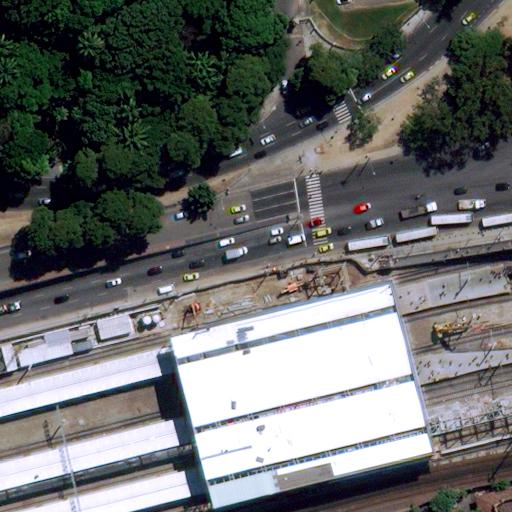

Original Image Size:
(512, 512)


In [6]:
# Get image and zoom.  We zoom here because the 512x512 image may product tags that are smaller than 50x50 
# and that is the min needed for Computer Vision to work

# download the files (only do once if you are running the cell multiple times comment out)
satimg_pd = dataset.to_pandas_dataframe(file_handling_option=FileHandlingOption.DOWNLOAD, target_path='./download/', overwrite_download=True)

# for now pull the first row in the df, TODO: iterate the df
im = Image.open(satimg_pd.loc[0,'image_url'])

print("Original Image:")
display(im)

print("Original Image Size:")
print(im.size)

# Convert to an array for zooming
ascent = np.asarray(im.convert('RGB'))

# Zoom the size (3x), but keep the third dimention (the RGB channel) the same so the colors aren't off
result = ndimage.zoom(ascent, (3.0,3.0,1.0), order=1)

# Create the image back from the array
im_big = Image.fromarray(result)

# Calculate the top/left x,y and the bottom/right x,y based on tag from % of the image 
topx = df['label'][0][0]['topX'] * im_big.size[0]
topy = int(df['label'][0][0]['topY'] * im_big.size[1])
bottomx = int(df['label'][0][0]['bottomX'] * im_big.size[0])
bottomy = int(df['label'][0][0]['bottomY'] * im_big.size[1])

# Determine and fix if we don't have enough (50x50) for Computer Vision
enoughx = bottomx - topx
enoughy = bottomy - topy

# expand size for x with more pixels if needed
while enoughx < 50:
    enoughx = enoughx + 2
    topx = topx - 1
    bottomx = bottomx + 1

# expand size for y with more pixels if needed
while enoughy < 50:
    enoughy = enoughy + 2
    topy = topy - 1
    bottomy = bottomy + 1

# crop the image with the new xy
cropped = im_big.crop((topx, topy, bottomx, bottomy))
print("Cropped Image:")
display(cropped)

# save crop in local directory (TODO: just stream the bits into an array that we can send to ComputerVision without having to save to file)
cropped.save('crop.jpg')

{
  "color": {
    "dominantColorForeground": "Red",
    "dominantColorBackground": "Grey",
    "dominantColors": [
      "Red",
      "Grey"
    ],
    "accentColor": "9E2E2D",
    "isBwImg": false,
    "isBWImg": false
  },
  "requestId": "ffc4bbbd-61c0-4011-85a4-52b12eff55b0",
  "metadata": {
    "width": 64,
    "height": 51,
    "format": "Jpeg"
  }
}
tag: Red


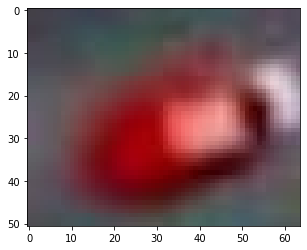

In [16]:
# Run through Computer Vision

# Get image (TODO: find a way not to save it but push to computer vision directly)
image_path = "./crop.jpg"

# Read the image into a byte array
image_data = open(image_path, "rb").read()

# Setup for the Cognitive Services call
analyze_url = cognitive_services_endpoint + "vision/v2.1/analyze"
headers = {
    'Ocp-Apim-Subscription-Key': cognitive_services_subscription_key,
    'Content-Type': 'application/octet-stream'
    }
params = {'visualFeatures': 'Color'}

# Call the Computer Vision Service
response = requests.post(analyze_url, headers=headers, params=params, data=image_data)
response.raise_for_status()

# Examine the output
print(json.dumps(response.json(), indent = 2, separators=(',', ': ')))
tags = response.json()

# Display the image
image = Image.open(BytesIO(image_data))
plt.imshow(image)
print("tag: " + response.json()['color']['dominantColorForeground'])

In [ ]:
dataset_updated = dataset_updated.register(workspace = ws,
                                 name = dataset_name,
                                 description = 'updated dataset',
                                 create_new_version = True)

In [ ]:
# write back a file to the same workspace

df.to_csv('dataset.csv')
blob_datastore.upload(src_dir='../', target_path='../')
dataset_updated = Dataset.Tabular.from_delimited_files(blob_datastore.path('../dataset.csv'))


In [ ]:
df.to_json("finaldata2.jsonl", orient="records", lines=True)

In [ ]:
df['label'][0][0]['topX']

## Playground


In [ ]:
img.shape
 

In [ ]:
# to show us the actual img snip we get from the coordinates
# import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1
    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask>0
    return image[m].reshape((y2+1-y1, x2+1-x1))
# img = sp.lena()
image_cropped = crop(img, 349,370,202,212)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(image)
ax2.imshow(image_cropped)
plt.show()

In [ ]:
import requests

import matplotlib.pyplot as plt
import json
from PIL import Image
from io import BytesIO

# If you are using a Jupyter notebook, uncomment the following line.
%matplotlib inline

# Add your Computer Vision subscription key and endpoint to your environment variables.
subscription_key = 'b8397be385f54209a4b250d9a3d7f982'
endpoint = "https://eastus.api.cognitive.microsoft.com/"

analyze_url = endpoint + "vision/v2.1/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://ckahrsmantechstorage.blob.core.windows.net/mantech/veh1.JPG"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'visualFeatures': 'Color'}
#data = {'url': image_url}
#response = requests.post(analyze_url, headers=headers, params=params, json=data)
response = requests.post(analyze_url, headers=headers, params=params, data=cropped)

response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(json.dumps(response.json(), indent = 2, separators=(',', ': ')))


# Display the image and overlay it with the caption.
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")

plt.show()

In [ ]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# # Add your Computer Vision subscription key and endpoint to your environment variables.
# if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#     subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
# else:
#     print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#     sys.exit()

# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

# analyze_url = endpoint + "vision/v3.0/analyze"

# # Set image_path to the local path of an image that you want to analyze.
# # Sample images are here, if needed:
# # https://github.com/Azure-Samples/cognitive-services-sample-data-files/tree/master/ComputerVision/Images
# image_path = "C:/Documents/ImageToAnalyze.jpg"
image_path = "./crop.jpg"


# Read the image into a byte array
image_data = open(image_path, "rb").read()
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type': 'application/octet-stream'}
params = {'visualFeatures': 'Color'}
response = requests.post(
    analyze_url, headers=headers, params=params, data=image_data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
# analysis = response.json()
# print(analysis)
print(json.dumps(response.json(), indent = 2, separators=(',', ': ')))
# image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(image_data))
plt.imshow(image)
# plt.axis("off")
# _ = plt.title(image_caption, size="x-large", y=-0.1)

## Playground 2


In [ ]:
from azure.storage.blob import BlobServiceClient, ContainerClient

blob_service_client = BlobServiceClient.from_connection_string("DefaultEndpointsProtocol=https;AccountName=ckahrsmantechstorage;AccountKey=FUjBTCqAW6pRv0u+004Hc6eXfh14ly26ZdgK6sVfugEhIMeaUY1fbgDbs6aJp6a77K4ZJrbsdaqLhSEMJTDqTg==;EndpointSuffix=core.windows.net")
all_containers = blob_service_client.list_containers(include_metadata=True)
for container in all_containers:
    print(container['name'], container['metadata'])
    container_client = blob_service_client.get_container_client(container['name'])
    generator = container_client.list_blobs()

    #code below lists all the blobs in the container and downloads them one after another
    for blob in generator:
        print("   " + blob.name)

In [ ]:
# Create a blob client using the local file name as the name for the blob
blob_client = blob_service_client.get_blob_client(container='satimages', blob='finaldata.json')



# Upload the created file
with open("finaldata.json", "rb") as data:
    blob_client.upload_blob(data)

In [ ]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.zoom(ascent, 2.0)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()

In [ ]:
ascent

In [ ]:
np.asarray(im.convert('L'))